## Libraries

In [ ]:
import matplotlib.pyplot as plt


# import tensorflow as tf
from tensorflow.keras.models import Sequential                              # to create a squential model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense       # to create the layers in the model
from tensorflow.keras.optimizers import Adam                                # using Adam optimizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator         # to generate batches of tensor image data (also with data augmentation)

## Data

Load dataset

In [ ]:
# download the zip file
! wget -O img_data.zip https://github.com/GovardhanPadmanabhan/Face-Mask-Detection-Tool/blob/main/img_data.zip?raw=true

# unzip the zip file
! unzip img_data.zip

# delete the zip file after unzipping
! rm img_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/with/1008.jpg    
  inflating: images/with/1009.jpg    
  inflating: images/with/101.jpg     
  inflating: images/with/1010.jpg    
  inflating: images/with/1011.jpg    
  inflating: images/with/1012.jpg    
  inflating: images/with/1013.jpg    
  inflating: images/with/1014.jpg    
  inflating: images/with/1015.jpg    
  inflating: images/with/1016.jpg    
  inflating: images/with/1017.jpg    
  inflating: images/with/1018.jpg    
  inflating: images/with/1019.jpg    
  inflating: images/with/102.jpg     
  inflating: images/with/1020.jpg    
  inflating: images/with/1021.jpg    
  inflating: images/with/1022.jpg    
  inflating: images/with/1023.jpg    
  inflating: images/with/1025.jpg    
  inflating: images/with/1026.jpg    
  inflating: images/with/1027.jpg    
  inflating: images/with/1028.jpg    
  inflating: images/with/1029.jpg    
  inflating: images/with/103.jpg     
  inflating: images/with/1030.jpg    



*   Perform image augmentation  
> * Normalize pixel values
> * Randomly rotate images between 0-40&deg;
> * Randomly shift images along x- and/or y-axis by 20%
> * Randomly zoom images in or out by 20%
> * Randomly flip images horizontally
> * Add new pixels around the boundary when the image is rotated and/or shifted
> * Encode the images' class into 1D binary label

<br>

*   Split images into training and validation (80:20)



In [ ]:
## the directory to the image dataset
directory = "images"                    # this is the resulting folder after unzipping the `img_data.zip` file
                                        # must contain one subdirectory per class


## create an instance of `ImageDataGenerator`
img_datagen = ImageDataGenerator(validation_split=0.2,                  # splits the data into training (80%) and validation (20%)
                                 rescale=1./255,                        # transform every pixel value from range [0, 255] to range [0, 1]
                                 rotation_range=40,                     # randomly roate images between 0 - 40 degrees
                                 width_shift_range=0.2,                 # shift images along x-axis by 20%
                                 height_shift_range=0.2,                # shift images along y-axis by 20%
                                 zoom_range=0.2,                        # randomly zoom in or zoom out images by 20%
                                 horizontal_flip=True,                  # randomly flip images horizontally
                                 fill_mode='nearest')                   # add new pixels (to make it seem like its stretching) when the image is rotated or shifted


## generate batches of augmented data for training
train_generator = img_datagen.flow_from_directory(directory,                # path to the target directory
                                                  target_size=(70,70),      # if not already in the specified dimension, resize images
                                                  batch_size=64,            # size of batches of image data
                                                  color_mode='rgb',         # images will have 3 channels
                                                  class_mode='binary',      # output class will be 1D binary labels
                                                  shuffle=True,             # shuffle the images
                                                  seed=42,                  # seed for shuffling and transformations (to make them reproducible)
                                                  subset='training')        # specify that this is the training set


## generate batches of augmented data for validation
validation_generator = img_datagen.flow_from_directory(directory,               # path to the target directory
                                                       target_size=(70,70),     # if not already in the specified dimension, resize images
                                                       batch_size=64,           # size of batches of image data
                                                       color_mode='rgb',        # images will have 3 channels
                                                       class_mode='binary',     # output class will be 1D binary labels
                                                       subset='validation')     # specify that this is the validation set

Found 8011 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


Display a batch of images and labels used in training

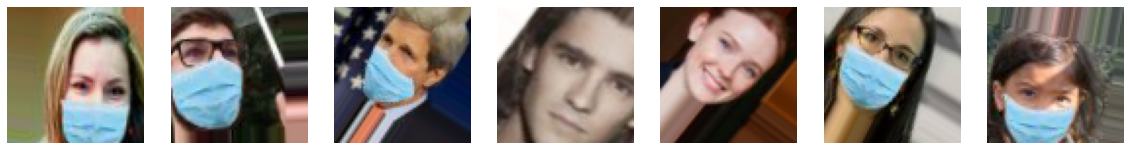

[0. 0. 0. 1. 1. 0. 0.]


In [ ]:
# get a batch of images and its labels from the training dataset
imgs, labels = next(train_generator)


# plot the images
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,20))
axes = axes.flatten()
for i, ax in zip(imgs, axes):
    ax.imshow(i)
    ax.axis('off')
plt.show()


# '0' label -> wearing mask
# '1' label -> not wearing mask or nor wearing it properly
print(labels[:7])

## CNN

A Sequential model is used here:



*   Conv2D + MaxPool2D
> * 1st layer (*Input Layer*) has input shape (70, 70, 3). With max pooling, output shape is (35, 35, 32)
> * 2nd layer, with max pooling, has output shape (17, 17, 32)
> * 3rd layer, with max pooling, has output shape (8, 8, 64)

*   After the 3rd layer, we flatten the shape, which results in (4096,) shape

*   Dense Layer
> * 4th layer has output shape (64,)
> * Final layer has output shape (1,)
> > * Sigmoid activation function is used here to give output within [0, 1]




In [ ]:
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(70,70,3)),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Flatten(),
                    Dense(units=64, activation='relu'),
                    Dense(units=1, activation='sigmoid'),
                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

Compile the model

In [ ]:
# Adam optimizer with 0.0001 learning rate
# binary_crossentropy for loss
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train the model

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    batch_size=64)

Epoch 1/50
126/126 [==============================] - 64s 504ms/step - loss: 0.6216 - accuracy: 0.6566 - val_loss: 0.5376 - val_accuracy: 0.7268
Epoch 2/50
126/126 [==============================] - 63s 503ms/step - loss: 0.4042 - accuracy: 0.8097 - val_loss: 0.4450 - val_accuracy: 0.7937
Epoch 3/50
126/126 [==============================] - 63s 500ms/step - loss: 0.3584 - accuracy: 0.8415 - val_loss: 0.4034 - val_accuracy: 0.8202
Epoch 4/50
126/126 [==============================] - 63s 499ms/step - loss: 0.3134 - accuracy: 0.8692 - val_loss: 0.3710 - val_accuracy: 0.8447
Epoch 5/50
126/126 [==============================] - 63s 497ms/step - loss: 0.2784 - accuracy: 0.8855 - val_loss: 0.3538 - val_accuracy: 0.8462
Epoch 6/50
126/126 [==============================] - 61s 481ms/step - loss: 0.2700 - accuracy: 0.8899 - val_loss: 0.3418 - val_accuracy: 0.8596
Epoch 7/50
126/126 [==============================] - 61s 486ms/step - loss: 0.2577 - accuracy: 0.8939 - val_loss: 0.3078 - val_ac

(Optional) Save the model

In [ ]:
# saving the model as `.h5` format
model.save("face_mask_detector.h5")

## Plots

Plot the training and validation loss

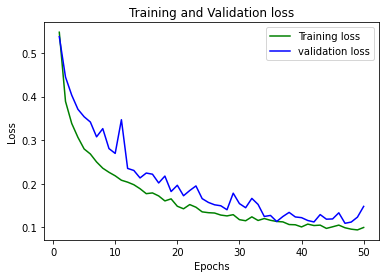

In [ ]:
#Plotting the loss of validation and training 
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochstoplot = range(1,51)
plt.plot(epochstoplot, loss_train, 'g', label='Training loss')
plt.plot(epochstoplot, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the training and validation accuracy

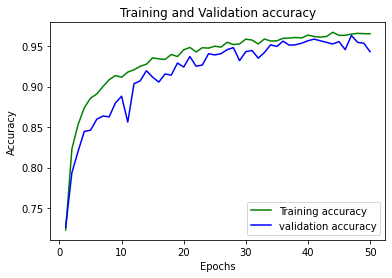

In [ ]:
#Plotting the accuracy of validation and training 
accur_train = history.history['accuracy']
accur_val = history.history['val_accuracy']
plt.plot(epochstoplot, accur_train, 'g', label='Training accuracy')
plt.plot(epochstoplot, accur_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()